# Tutorial 8

#### Example: Policy gradient on the CartPole environment

In this example, we perform reinforcement learning on the [OpenAI gym](https://www.gymlibrary.dev/) library.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli

import matplotlib.pyplot as plt
import numpy as np
from itertools import count
import gym
import pdb

With CartPole:
- the action space is $\{0, 1\}$ indicating the direction of the fixed force the cart is pushed with. $0$ pushes the cart to the left, while $1$ pushes the cart to the right
- the state space if 4-dimensional

We use a Bernoulli distribution for the **randomized** policy, i.e. the output is the probability of having zero as an action.

In [2]:
class PolicyANN(nn.Module):
    def __init__(self):
        super(PolicyANN, self).__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = torch.sigmoid(self.fc3(x))
        return probs

In [3]:
def reinforce(env, policy_est, num_episodes=2000, batch_size=5, gamma=0.99):

    # define optimizer
    optimizer = optim.Adam(policy_est.parameters(), lr=0.01)
    
    # set up lists to hold events
    total_rewards = []
    
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    ep = 0
    
    while ep < num_episodes:
        # initialize the state of the environment
        s_0 = env.reset()[0]
        states = []
        rewards = []
        actions = []
        done = False
        step = 0
        
        
        while done == False:
            step += 1
            
            # get actions from the Bernoulli policy
            probs = policy_est(torch.from_numpy(s_0).float()) # get parameters of the distribution
            action_dist = Bernoulli(probs) # create the distribution
            action = action_dist.sample() # sample from the distribution
            action = action.data.numpy().astype(int)[0] # transform to numpy
            
            # move forward in the environment
            s_1, r, done, _, _ = env.step(action)
            
            # store events in the lists
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            
            # update the current state of the environment
            s_0 = s_1
            
            # stop if the number of steps is greater than 500
            if step >= 200:
                done = True
            
            # if done, batch data
            if done:
                
                # calculate discounted rewards
                discount_rewards = np.zeros(len(rewards))
                cumulative_rewards = 0
                for i in reversed(range(0, len(rewards))):
                    cumulative_rewards = cumulative_rewards * gamma + rewards[i]
                    discount_rewards[i] = cumulative_rewards
                
                # store batch
                batch_rewards.extend(discount_rewards)
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                
                total_rewards.append(sum(rewards))
                
                # if batch size, update network
                if batch_counter == batch_size:
                    
                    # zero out the gradient
                    optimizer.zero_grad()
                    
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # calculate loss
                    probs = policy_est(state_tensor)
                    m = Bernoulli(probs)
                    logprob = torch.diagonal(-m.log_prob(action_tensor.float()))
                    loss = torch.mean( logprob * reward_tensor )
                    
                    loss.backward()
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-100:])
                # print running average
                print("\rEp: {:5d} Average of last 100: {:.2f}".format(ep + 1, avg_rewards), end="")
                ep += 1
                
    return total_rewards

In [4]:
env = gym.make('CartPole-v1')
policy_est = PolicyANN()
rewards = reinforce(env, policy_est)

Ep:    39 Average of last 100: 26.44

C:\Users\antho\AppData\Local\Temp/ipykernel_7892/3437882814.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  state_tensor = torch.FloatTensor(batch_states)


Ep:  2000 Average of last 100: 200.00

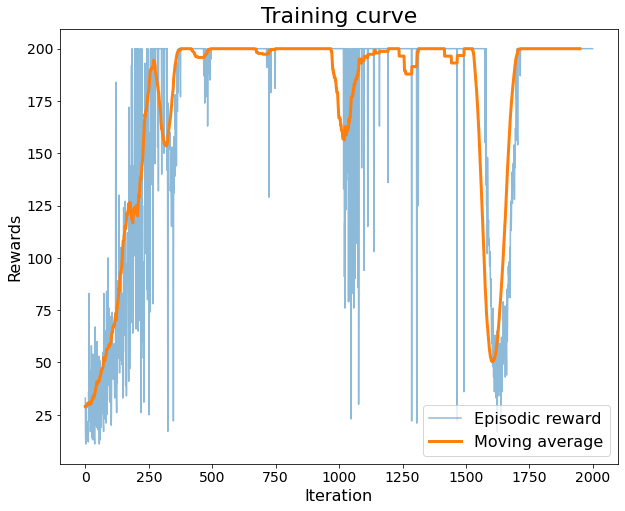

In [5]:
# compute moving average of losses
n = 50
MA = np.mean(np.array([rewards[i:i+n] for i in range(len(rewards)-n)]), axis=1)    

fig, axes = plt.subplots(figsize=(10,8))
axes.plot(rewards, linewidth=1.5, label="Episodic reward", alpha=0.5)
axes.plot(MA, linewidth=3, label="Moving average")
axes.set_xlabel('Iteration',fontsize=16)
axes.set_ylabel('Rewards',fontsize=16)
axes.set_title("Training curve", fontsize=22)
axes.tick_params(axis='both', labelsize=14)
axes.legend(fontsize=16)
plt.show()